# CTL relevant search results

This notebook demonstrates how we're inferring which items are the most relevant to a given search query in the Chicago Tool Library database.
We assume that relevant items are more likely to be viewed or have a hold placed on them following a search.

Following that assumption, for each frequent query we can build an ordered list of the most relevant items for each query using the following procedure:
1. Find all items views and subsequent holds for all queries using search log data.
2. Apply some weight to each view and each hold (e.g., holds count twice towards relevance as much as views)
3. Adjust for position bias (i.e., items that appear at the top of the results are more likely to be clicked, so we should give extra relevance if lower results were clicked)
4. Sum the position-adjusted view and hold scores to calculate a relevance score for each item for the given query.
5. Sort by relevance score.

**There is (at least) one substantial flaw with this methodology.**
It won't identify relevant items if they are not currently returned by the search functionality (because those items would have no views from the search results).
However, (we think) we have more of a precision/ranking problem than a recall problem—that is, all relevant items are returned for most queries, just in the wrong order—so it's probably safe to overlook this flaw.

In [1]:
from typing import Literal
from urllib.parse import unquote

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sqlalchemy import create_engine, text, func

In [2]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 50)

In [3]:
def lowercase_and_strip(col: str):
    return pl.col(col).str.to_lowercase().str.strip_chars()

# connect to db and load data

Read item data from the PostgreSQL database.
We'll use this for item attributes (name, status, etc.).

For search, view, and hold data, we'll read from the `relevant_search_results.csv` file.
This CSV has one record per "item viewed" event from the search results page.
It is the output from the `relevant_search_results.sql` query, which pulls from the search logs in the `ahoy_events` table.

In [4]:
engine = create_engine("postgresql+psycopg2://Daniel@localhost:5432/circulate_development")

In [5]:
df = pl.read_database("select * from items", engine)
df.head()

id,name,size,brand,model,serial,created_at,updated_at,number,status,borrow_policy_id,strength,quantity,checkout_notice,holds_count,other_names,power_source,location_area,location_shelf,library_id,plain_text_description,url,purchase_link,purchase_price_cents,myturn_item_type,holds_enabled,accessories,retired_reason
i64,str,str,str,str,str,datetime[μs],datetime[μs],i64,str,i64,str,i64,str,i64,str,str,str,str,i64,str,str,str,i64,str,bool,list[str],str
3005,"""Slow Bolting Cilantro""","""""","""Back to the Roots""","""""","""""",2022-03-30 00:38:31.413973,2022-11-03 22:42:06.193891,3186,"""retired""",4,"""""",0,"""""",2,"""""",null,"""""","""""",1,"""""","""https://backtotheroots.com/pro…",null,null,null,true,[],null
1822,"""Knife sharpener""","""""","""Chefs Choice""","""100""","""54405F06""",2021-03-04 00:40:49.217824,2022-11-03 15:46:02.787040,2362,"""retired""",1,"""""",null,"""""",11,"""""","""electric (corded)""","""""","""""",1,"""""","""""","""https://www.amazon.com/ChefsCh…",17921,"""""",true,[],null
3967,"""Flooring roller""","""3 inch wide x 1.5 inch diamete…","""Beno J Gundlach Co""","""J200B""","""""",2023-06-27 19:43:34.433737,2023-06-27 22:48:32.488852,3981,"""active""",1,"""""",null,"""""",2,"""Flooring roller, floor roller,…",null,"""Flooring drawers""","""""",1,"""Used for applying even pressur…","""https://www.homedepot.com/p/Gu…","""https://www.homedepot.com/p/Gu…",1700,"""""",true,[],null
4969,"""Radius jig""","""R35, R40""","""Xuhal""","""""","""""",2024-04-18 22:15:53.519421,2024-04-18 22:29:04.119207,4880,"""active""",1,"""""",null,"""""",1,"""router template, radius templa…",null,"""Aisle 3""","""Jigs & joiners""",1,"""Number after R is in mm (milli…","""""","""https://www.amazon.com/dp/B0C6…",999,"""""",true,[],null
3847,"""Finger sanding multitool attac…","""3.15 x 1.4 inches""","""""","""""","""""",2023-05-04 22:54:18.958866,2025-03-14 19:18:16.811523,3862,"""retired""",1,"""Hook and loop attachment""",null,"""""",0,"""detail sander, oscillating, fi…",null,"""Power tools""","""Multitool""",1,"""Used for sanding in tight spac…","""""","""""",500,"""""",true,[],null


In [6]:
# remove my visits because I was likely just testing the search behavior
MY_VISIT_IDS = [
    49827,
    67171,
    114696,
    116022,
    118109,
    118368,
    118995,
    124701,
    125090,
    127437,
]

query_df = pl.read_csv("./data/relevant_search_results.csv")

# clean up some queries
query_df = (
    query_df
    .filter(~pl.col("visit_id").is_in(MY_VISIT_IDS))
    .with_columns(pl.col("query").map_elements(lambda x: unquote(x), return_dtype=str))  # remove URL encoding (e.g., "%20" -> " ")
    .with_columns(lowercase_and_strip("query").alias("query"))  # remove leading/trailing whitespace
)
query_df.head()

visit_id,query,item_id,item_name,search_index,view_time,hold_id
i64,str,i64,str,i64,str,i64
73499,"""mig welder""",490,"""MIG welder""",1,"""2024-08-01 16:00:54 UTC""",null
73568,"""miter""",836,"""Sliding compound miter saw""",12,"""2024-08-01 15:47:35 UTC""",41370
73588,"""bosch""",111,"""Orbital sander""",1,"""2024-08-01 16:21:10 UTC""",null
73611,"""cricut""",3632,"""Digital cutting machine""",2,"""2024-08-01 16:30:10 UTC""",null
73611,"""cricut""",4271,"""Digital cutting machine""",3,"""2024-08-01 16:31:02 UTC""",null


# calculate relevance

Assign weights for relative importance of views and holds, set parameters for position bias adjustment (see below), then compute relevance scores for all items for each query.

In [7]:
VIEW_WEIGHT = 1
HOLD_WEIGHT = 2
ALPHA = 0.4  # for position bias adjustment -- P(view|position i) = 1 / (i**alpha) (see below)
MAX_I = 100  # stop increasing positional bias beyond this index

relevance_df = (
    query_df
    .with_columns(lowercase_and_strip("item_name").alias("item_name"))
    .with_columns(pl.when(pl.col("search_index") > MAX_I).then(MAX_I).otherwise(pl.col("search_index")).alias("capped_index"))
    .with_columns((1 / (pl.col("capped_index") ** ALPHA)).alias("bias_adjustment"))
    .with_columns(
        pl.when(pl.col("view_time").is_not_null())
        .then(VIEW_WEIGHT / pl.col("bias_adjustment"))
        .alias("view_score")
    )
    .with_columns(
        pl.when(pl.col("hold_id").is_not_null())
        .then(HOLD_WEIGHT / pl.col("bias_adjustment"))
        .alias("hold_score")
    )
    .group_by(
        "query",
        # "item_id",
        "item_name",
    )
    .agg(
        pl.median("search_index").alias("median_index"),
        pl.count("view_time").alias("view_count"),
        pl.count("hold_id").alias("hold_count"),
        pl.sum("view_score").alias("view_score"),
        pl.sum("hold_score").alias("hold_score"),
    )
    .with_columns(
        (pl.col("view_count") + pl.col("hold_count")).alias("view_plus_hold_count"),
        (pl.col("view_score") + pl.col("hold_score")).alias("score"),
    )
    .with_columns((pl.col("score") / pl.max("score").over("query")).alias("normalized_score"))
    .with_columns(pl.sum("view_count").over("query").alias("query_view_count"))
    .with_columns(pl.col("score").rank(descending=True, method="ordinal").over("query").alias("rank"))
    .sort(["query_view_count", "query", "rank"], descending=[True, False, False])
)

relevance_df.head()

query,item_name,median_index,view_count,hold_count,view_score,hold_score,view_plus_hold_count,score,normalized_score,query_view_count,rank
str,str,f64,u32,u32,f64,f64,u32,f64,f64,u32,u32
"""sander""","""orbital sander""",6.0,385,111,851.554085,439.729382,496,1291.283467,1.0,1258,1
"""sander""","""detail sander""",5.0,265,45,641.031424,229.017533,310,870.048956,0.673786,1258,2
"""sander""","""sheet sander""",11.0,219,37,639.542588,173.463509,256,813.006097,0.629611,1258,3
"""sander""","""belt sander""",38.0,66,5,234.514713,33.076053,71,267.590766,0.207229,1258,4
"""sander""","""oscillating multi-tool""",67.0,56,1,238.613157,5.023773,57,243.63693,0.188678,1258,5


## position bias adjustment

It's not trivial to extract relevance from counting views and holds because of **positional bias.**
Items that show up at the top of the results are much more likely to be clicked on, even if they are less relevant than lower results.

I implemented a simple position bias adjustment above. 
I found that $\alpha = 0.4$ gave good subjective results on some common queries.
This positional bias adjustment is **not based on any empirical observations** in our dataset, so there is **opportunity for refinement** here in the future.

---

There are a few things this position bias adjustment does *not* account for:

* Another bias that is difficult (impossible?) to correct for is that people are less likely to click items that are unavailable, checked out, or in maintenance, even if those items are relevant.
For very popular items, that might suppress the number of views/holds on the most relevant results.

* Another thing that's hard to account for is that sometimes people view items for other reasons than relevance.
I've seen this described as "attractiveness" rather than "relevance".
An example in the CTL dataset is that people view "3d printer" fairly often when they search for "camera".
It's obviously not relevant to the search, but it catches people's eye so they click on it.

---

The chart below illustrates how the position bias adjustment works.
If an item is viewed at a given position on the x-axis, then its view score will be divided by the y-value.
This has the effect of boosting the scores for items that are clicked from farther down in the list, with larger $\alpha$ values giving a larger boost.

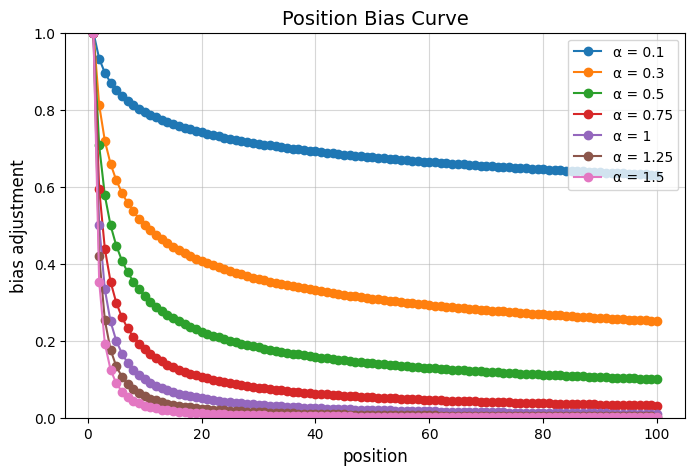

In [8]:
# Parameters for the position bias curve
n = 100
alpha_list = [0.1, 0.3, 0.5, 0.75, 1, 1.25, 1.5]
positions = np.arange(1, n+1)

# Plot the curve
plt.figure(figsize=(8, 5))
for alpha in alpha_list:
    bias = 1 / (positions ** alpha)
    normalized_bias = bias / bias[0]
    plt.plot(positions, normalized_bias, marker='o', label=f'α = {alpha}')
plt.title("Position Bias Curve", fontsize=14)
plt.xlabel("position", fontsize=12)
plt.ylabel("bias adjustment", fontsize=12)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [9]:
relevance_df.filter(pl.col("query") == "table saw").to_pandas()

,query,item_name,median_index,view_count,hold_count,view_score,hold_score,view_plus_hold_count,score,normalized_score,query_view_count,rank
0,table saw,portable table saw,9.0,349,62,852.606602,290.187962,411,1142.794564,1.000000,923,1
1,table saw,benchtop table saw,4.0,195,30,343.514926,105.081486,225,448.596412,0.392543,923,2
2,table saw,jobsite table saw,1.0,125,17,159.406383,40.189314,142,199.595697,0.174656,923,3
3,table saw,table saw safety bundle,10.0,35,7,86.346211,31.945255,42,118.291466,0.103511,923,4
4,table saw,router table with router,19.0,33,0,106.887845,0.000000,33,106.887845,0.093532,923,5
5,table saw,combo miter/ table saw,1.0,57,4,58.278032,8.000000,61,66.278032,0.057996,923,6
6,table saw,clamping workbench,21.0,14,3,44.535276,15.394039,17,59.929316,0.052441,923,7
7,table saw,push stick,29.0,7,4,26.030434,28.785844,11,54.816278,0.047967,923,8
8,table saw,scroll saw,25.0,13,1,41.732619,9.408632,14,51.141252,0.044751,923,9
9,table saw,mini cut-off saw,15.0,18,0,50.680060,0.000000,18,50.680060,0.044347,923,10


# calculate ranking metrics

Define metrics for evaluating ranking quality.
We'll primarily use [normalized discounted cumulative gain (NDCG)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain).
NDCG scores highly if the most relevant items are at the top of the search results.

In [10]:
def precision_at_k(
    retrieved: list,
    relevant: set | dict,
    k: int,
) -> float:
    if len(retrieved) == 0:
        return 0.0
    retrieved = retrieved[:k]
    return len([x for x in retrieved if x in relevant]) / len(retrieved)


def recall_at_k(
    retrieved: list,
    relevant: set | dict,
    k: int,
) -> float:
    if len(relevant) == 0:
        return 0.0
    retrieved = retrieved[:k]
    return len([x for x in retrieved if x in relevant]) / len(relevant)


def dcg_at_k(
    retrieved: list,
    relevant: set | dict,  # {item: relevance_score}
    k: int,
    dcg_type: Literal["linear", "exponential"] = "linear",
) -> float:
    if len(retrieved) == 0:
        return 0.0
    
    relevant = _validate_relevant_dict(relevant)

    retrieved = retrieved[:k]
    if dcg_type == "linear":
        # linear discounting: rel_i / log2(i+2)
        return sum(relevant.get(x, 0) / np.log2(i + 2) for i, x in enumerate(retrieved))
    else:
        # exponential discounting: (2^rel_i - 1) / log2(i+2)
        return sum((2 ** relevant.get(x, 0) - 1) / np.log2(i + 2) for i, x in enumerate(retrieved))


def ndcg_at_k(
    retrieved: list,
    relevant: set | dict,  # {item: relevance_score}
    k: int,
    dcg_type: Literal["linear", "exponential"] = "linear",
) -> float:
    relevant = _validate_relevant_dict(relevant)
    dcg = dcg_at_k(retrieved, relevant, k, dcg_type)
    ideal_order = sorted(relevant, key=lambda x: relevant[x], reverse=True)
    idcg = dcg_at_k(ideal_order, relevant, k, dcg_type)
    return dcg / idcg if idcg > 0 else 0.0


def _validate_relevant_dict(relevant: set | dict):
    if isinstance(relevant, dict):
        return relevant
    elif isinstance(relevant, set):
        return {x: 1 for x in relevant}
    else:
        raise ValueError(f"invalid type: {type(relevant)}")

## validate NDCG implementation

Validate that function returns the same result as the standard `sklearn` implementation.
(I reimplemented to make it easier to apply to a dataframe.)

In [11]:
relevance_scores = {
    "item1": 1,
    "item2": 2,
    "item3": 0.5,
}

predicted_ranking = ["item1", "item2", "item3", "item4", "item5"]

k = 3

precision_k = precision_at_k(predicted_ranking, relevance_scores, k)
recall_k = recall_at_k(predicted_ranking, relevance_scores, k)
out = ndcg_at_k(predicted_ranking, relevance_scores, k)

print(f"precision@k: {precision_k:.4f}")
print(f"recall@k: {recall_k:.4f}")
print(f"NDCG@{k}: {out:.4f}")

precision@k: 1.0000
recall@k: 1.0000
NDCG@3: 0.8719


In [12]:
out = ndcg_at_k(predicted_ranking, relevance_scores, k, "exponential")

print(f"NDCG@{k}: {out:.4f}")

NDCG@3: 0.8077


In [13]:
from sklearn.metrics import ndcg_score
import numpy as np

k = 3

true_relevance = [relevance_scores.get(x, 0) for x in predicted_ranking]
predicted_relevance = [len(predicted_ranking) - i for i in range(len(predicted_ranking))]

true_relevance_2d = np.array([true_relevance])
predicted_relevance_2d = np.array([predicted_relevance])

out = ndcg_score(true_relevance_2d, predicted_relevance_2d, k=k)

print(f"NDCG@{k}: {out:.4f}")


NDCG@3: 0.8719


## calculate NDCG on CTL query data

In [14]:
def pg_search(search_term: str, weights: dict[str, str] = None) -> pl.DataFrame:
    """
    Implement PostgreSQL full text search. This query is equivalent to how searches
    are executed in the Rails app.
    """
    if weights is None:
        weights = _get_default_weights()

    ts_rank_str = " || ".join([f"setweight(to_tsvector('english', {k}::text), '{v}')" for k, v in weights.items()])
    ts_rank_str = f"ts_rank({ts_rank_str}, to_tsquery('english', :search_term))"
    where_str = " || ".join([f"to_tsvector('english', {k}::text)" for k in weights.keys()])
    where_str = f"({where_str} @@ to_tsquery('english', :search_term))"
    prefix_search_term = "&".join([f"{word}:*" for word in search_term.split(" ")])
    
    query = text(f"""
        SELECT
            '{search_term}' as query,
            id,
            name as item_name,
            number,
            other_names,
            brand,
            plain_text_description,
            size,
            strength,
            {ts_rank_str} AS search_score
        FROM items
        WHERE 
            {where_str}
            AND status NOT IN ('retired', 'missing', 'pending')
        ORDER BY
            search_score DESC,
            number
        ;
    """)
    query = query.bindparams(search_term=prefix_search_term)  # equivalent to {tsearch: {prefix: true}} in Rails app
    return (
        pl.read_database(query, engine)
        .with_columns(pl.col("search_score").rank(descending=True, method="ordinal").alias("search_rank"))
    )


def _get_default_weights() -> dict[str, str]:
    return {
        "name": "A",
        "number": "A",
        "other_names": "B",
        "brand": "C",
        "plain_text_description": "C",
        "size": "D",
        "strength": "D",
    }

In [15]:
pg_search("table saw").head()

query,id,item_name,number,other_names,brand,plain_text_description,size,strength,search_score,search_rank
str,i64,str,i64,str,str,str,str,str,f64,u32
"""table saw""",7793,"""Combo miter/ table saw""",5683,"""chop saw, mitre saw, power saw…","""Evolution""","""C-Tools loans must be approved…","""8-1/4 inch, 28.6 pounds""","""120V, 60Hz, 12A""",1.0,1
"""table saw""",8156,"""Combo miter/ table saw""",5728,"""chop saw, mitre saw, power saw…","""Evolution""","""C-Tools loans must be approved…","""8-1/4 inch, 28.6 pounds""","""120V, 60Hz, 12A""",1.0,2
"""table saw""",13671,"""Jobsite table saw""",6281,"""tablesaw, compact table saw, p…","""Dewalt""","""C-Tools loans must be approved…","""24"" rip capacity""","""15A, 120V AC, 60HZ""",1.0,3
"""table saw""",4175,"""Jobsite table saw""",4157,"""tablesaw, compact table saw, p…","""Dewalt""","""C-Tools loans must be approved…","""24"" rip capacity""","""15A, 120V AC, 60HZ""",0.9999997,4
"""table saw""",12809,"""Benchtop table saw""",6186,"""woodworking, rip saw, heavy du…","""Ryobi""","""C-Tools loans must be approved…","""8 1/4 inches""","""120V, 13A, 60HZ, 5700 r/min""",0.9995262,5


In [16]:
def collect_relevance_df(relevance_df: pl.DataFrame, level: Literal["name", "number"] = "name") -> pl.DataFrame:
    """
    Take the relevance dataframe and aggregate it into a format that can be passed into
    the `ndcg_at_k` function.
    """
    if level == "name":
        collect_col = "item_name"
    else:
        collect_col = "item_number"
        sql_query = "select name as item_name, number::text as item_number from items"
        item_df = (
            pl.read_database(sql_query, engine)
            .with_columns(lowercase_and_strip("item_name").alias("item_name"))
            .with_columns(pl.concat_str("item_number", pl.lit("-"), "item_name").alias("item_number"))
        )
        relevance_df = relevance_df.join(item_df, on=["item_name"], how="inner")

    return (
        relevance_df
        .group_by("query")
        .agg(
            pl.len().alias("n_relevant"),
            pl.sum("view_plus_hold_count").alias("view_plus_hold_count"),
            pl.col(collect_col).sort_by("rank").alias("relevant_list"),
            pl.col("normalized_score").sort_by("rank").alias("score_list"),
        )
        .sort("view_plus_hold_count", descending=True)
    )

In [17]:
relevant_name = collect_relevance_df(relevance_df, "name")
relevant_number = collect_relevance_df(relevance_df, "number")

In [18]:
relevant_name.head()

query,n_relevant,view_plus_hold_count,relevant_list,score_list
str,u32,u32,list[str],list[f64]
"""sander""",27,1493,"[""orbital sander"", ""detail sander"", … ""crowbar""]","[1.0, 0.673786, … 0.000774]"
"""saw""",91,1177,"[""compound miter saw"", ""reciprocating saw"", … ""diamond grit hole saw""]","[1.0, 0.851868, … 0.003863]"
"""table saw""",26,1063,"[""portable table saw"", ""benchtop table saw"", … ""pocket-hole jig""]","[1.0, 0.392543, … 0.000875]"
"""sewing machine""",12,933,"[""sewing machine"", ""sewing and quilting machine"", … ""drill bit set""]","[1.0, 0.164065, … 0.002175]"
"""miter saw""",20,802,"[""compound miter saw"", ""sliding compound miter saw"", … ""mini cut-off saw""]","[1.0, 0.463985, … 0.002647]"


In [19]:
def get_retrieved_df(query_list: list[str], level: Literal["name", "number"] = "name") -> pl.DataFrame:
    """
    Execute `pg_search` for all queries in `query_list`.
    """
    collect_col = "item_name" if level == "name" else "item_number"
    df_list = []
    
    for query in query_list:
        _df = pg_search(query)
        _df = _df.with_columns(lowercase_and_strip("item_name").alias("item_name"))
        if level == "name":
            # only keep the first instance of each item name
            _df = _df.filter(pl.cum_count("item_name").over("query", "item_name") == 1)
        else:
            _df = _df.with_columns(pl.concat_str("number", pl.lit("-"), "item_name").alias("item_number"))
        _df = (
            _df
            .group_by("query")
            .agg(pl.col(collect_col).alias("retrieved_list"))
        )
        df_list.append(_df)
    
    return pl.concat(df_list)

In [20]:
%%time
query_list = (
    query_df
    .group_by("query")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    # use either head or filter
    .head(20)
    # .filter(pl.col("count") >= 50)
    .select("query")
    .to_series()
    .to_list()
)

print(f"processing {len(query_list):,} queries")

retrieved_name = get_retrieved_df(query_list, "name")
retrieved_number = get_retrieved_df(query_list, "number")

processing 20 queries
CPU times: user 216 ms, sys: 196 ms, total: 412 ms
Wall time: 4.65 s


In [21]:
for x in query_list:
    print(x, end=", ")

sander, saw, table saw, sewing machine, carpet cleaner, power washer, miter saw, nail gun, drill, circular saw, router, tent, cricut, tiller, camping, hammer drill, planer, sewing, pressure washer, aerator, 

In [22]:
retrieved_name.head()#, retrieved_number.head()

query,retrieved_list
str,list[str]
"""sander""","[""detail sander"", ""finish sander"", … ""abrasive cleaning stick""]"
"""saw""","[""reciprocating saw"", ""reciprocating saw scraper"", … ""striking knife""]"
"""table saw""","[""combo miter/ table saw"", ""jobsite table saw"", … ""compound miter saw""]"
"""sewing machine""","[""sewing machine"", ""sewing and quilting machine"", … ""air scrubber (please read item description)""]"
"""carpet cleaner""","[""carpet cleaner"", ""carpet cleaner - does not lock upright"", … ""wet-dry vac""]"


In [23]:
# combine retrieved and relevant items into a single dataframe
combined_name = retrieved_name.join(relevant_name, on=["query"], how="inner")
combined_number = retrieved_number.join(relevant_number, on=["query"], how="inner")

# TODO: do this better
count_df = query_df.group_by("query").agg(pl.len().alias("count"))
combined_name = combined_name.join(count_df, on=["query"], how="left")
combined_number = combined_number.join(count_df, on=["query"], how="left")

In [24]:
combined_name.head()

query,retrieved_list,n_relevant,view_plus_hold_count,relevant_list,score_list,count
str,list[str],u32,u32,list[str],list[f64],u32
"""sander""","[""detail sander"", ""finish sander"", … ""abrasive cleaning stick""]",27,1493,"[""orbital sander"", ""detail sander"", … ""crowbar""]","[1.0, 0.673786, … 0.000774]",1258
"""saw""","[""reciprocating saw"", ""reciprocating saw scraper"", … ""striking knife""]",91,1177,"[""compound miter saw"", ""reciprocating saw"", … ""diamond grit hole saw""]","[1.0, 0.851868, … 0.003863]",1065
"""table saw""","[""combo miter/ table saw"", ""jobsite table saw"", … ""compound miter saw""]",26,1063,"[""portable table saw"", ""benchtop table saw"", … ""pocket-hole jig""]","[1.0, 0.392543, … 0.000875]",923
"""sewing machine""","[""sewing machine"", ""sewing and quilting machine"", … ""air scrubber (please read item description)""]",12,933,"[""sewing machine"", ""sewing and quilting machine"", … ""drill bit set""]","[1.0, 0.164065, … 0.002175]",799
"""miter saw""","[""combo miter/ table saw"", ""compound miter saw"", … ""benchtop table saw""]",20,802,"[""compound miter saw"", ""sliding compound miter saw"", … ""mini cut-off saw""]","[1.0, 0.463985, … 0.002647]",662


In [25]:
def calculate_metrics(combined_df: pl.DataFrame, k_list: list[int], dcg_type: Literal["linear", "exponential"] = "linear"):
    """
    Calculate NDCG@k for the provided k values.
    """
    metrics_df = combined_df
    relevance_data = pl.struct("retrieved_list", "relevant_list", "score_list")
    
    for k in k_list:
        metrics_df = metrics_df.with_columns(
            relevance_data
            .map_elements(
                lambda x: ndcg_at_k(
                    retrieved=x["retrieved_list"],
                    relevant=dict(zip(x["relevant_list"], x["score_list"])),
                    k=k,
                    dcg_type=dcg_type,
                ),
                return_dtype=float
            )
            .alias(f"ndcg_at_{k}")
        )
    
    return metrics_df

In [26]:
k_list = [1, 5, 10, 20, 100]
drop_cols = [
    "retrieved_list",
    "relevant_list",
    "score_list",
    "n_relevant",
    "view_plus_hold_count",
]
metrics_name = calculate_metrics(combined_name, k_list).sort("count", descending=True).drop(drop_cols)
metrics_name.to_pandas()

,query,count,ndcg_at_1,ndcg_at_5,ndcg_at_10,ndcg_at_20,ndcg_at_100
0,sander,1258,0.673786,0.799261,0.802549,0.840156,0.838931
1,saw,1065,0.851868,0.545092,0.509590,0.623497,0.761651
2,table saw,923,0.057996,0.540369,0.560234,0.589289,0.597993
3,sewing machine,799,1.000000,0.997873,0.988858,0.987830,0.987830
4,carpet cleaner,787,0.632771,0.833878,0.828380,0.828380,0.828380
5,power washer,755,0.150630,0.692429,0.692429,0.692429,0.692429
6,miter saw,662,0.022663,0.636536,0.653815,0.654644,0.657779
7,nail gun,661,1.000000,0.885942,0.918795,0.932907,0.946214
8,drill,635,1.000000,0.878088,0.936234,0.923631,0.932756
9,circular saw,589,0.101250,0.633292,0.642301,0.678712,0.678269


In [27]:
metrics_name.mean()

query,count,ndcg_at_1,ndcg_at_5,ndcg_at_10,ndcg_at_20,ndcg_at_100
str,f64,f64,f64,f64,f64,f64
null,632.65,0.562976,0.727708,0.749612,0.768483,0.782292


# next steps

Now that we have a methodology for identifying relevant items and evaluating queries, we can try to modify our search implementation in a way that improves our evaluation metrics (NDCG).